# Parallel tasks on Aquila

For tasks with few qubits in the register, we can use parallel execution that makes use of full area allowed by the QPU. In this tutorial we go through the previously explored checkerboard preparation but now we take advantage of the full area. 

We will break up the register into __batches__ which will run in parallel.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
tracker = Tracker().start()

## Defining batches

First, we will define a _single_ batch containing a 3x3 square grid of atoms

In [2]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

In [3]:
import numpy as np

# distance between atoms
distance = 6.7e-6

# number of atoms in a batch
Lx = 3
Ly = 3

register = AtomArrangement()

for ix in range(Lx):
    for iy in range(Ly):
        pos = (ix * distance, iy * distance)
        register.add(pos)

## Bounding box

Next, we define a bounding box by calculating its width and height of the batch. This will prove useful in setting up multiple batches in parallel.

In [4]:
x_min = min(*[site.coordinate[0] for site in register])
x_max = max(*[site.coordinate[0] for site in register])
y_min = min(*[site.coordinate[1] for site in register])
y_max = max(*[site.coordinate[1] for site in register])

single_problem_width = x_max - x_min
single_problem_height = y_max - y_min

### Calculating batch placement

To prevent entanglement via the Rydberg interaction between batches, we need to place them far apart. Each batch needs an area occupied by its bounding box plus a padding that ensure proper separation.

We pick the distance between the batches to be $3 \times d$, where $d$ is the distance between neighboring atoms in a single batch. This means the ratio between intra- and inter-batch interaction strengths (using the van der Waals formula, $V = C_6/d^6$) is at most $\frac{1}{3^6} \approx 0.001372$.


In [5]:
import numpy as np
from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.aws import AwsDevice
import json

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# get values from device capabilities
field_of_view_width = qpu.properties.paradigm.lattice.area.width
field_of_view_height = qpu.properties.paradigm.lattice.area.height
n_site_max = qpu.properties.paradigm.lattice.geometry.numberSitesMax

# set distance between batches to be 3 x d
interproblem_distance = 3 * distance

# setting up a grid of problems filling the total area
n_width = int(float(field_of_view_width)   // (single_problem_width  + interproblem_distance))
n_height = int(float(field_of_view_height) // (single_problem_height + interproblem_distance))

## Generating registers for all batches

We now loop create the total set of registers that will run on the QPU. 

We will keep track of which set of registers (by atom number) belongs to which batch using a dictionary called `batch_mapping`.

We stop generating batches once we have reached the maximum number of sites allowed by the QPU. In this case we check to make sure we can fit the necessary number of atoms into a batch in case the number of atoms per batch is not a factor of `n_site_max`. 

In [6]:
batch_mapping = dict()
parallel_register = AtomArrangement()

atom_number = 0 #counting number of atoms added

for ix in range(n_width):
    x_shift = ix * (single_problem_width   + interproblem_distance)

    for iy in range(n_height):    
        y_shift = iy * (single_problem_height  + interproblem_distance)

        # reached the maximum number of batches possible given n_site_max
        if atom_number + len(register) > n_site_max: break 

        atoms = []
        for site in register:
            new_coordinate = (x_shift + site.coordinate[0], y_shift + site.coordinate[1])
            parallel_register.add(new_coordinate,site.site_type)

            atoms.append(atom_number)

            atom_number += 1

        batch_mapping[(ix,iy)] = atoms

In [7]:
# Key indicates the position of the batch itself on a unitless grid, 
# with dictionary value being the atom number
batch_mapping

{(0, 0): [0, 1, 2, 3, 4, 5, 6, 7, 8],
 (0, 1): [9, 10, 11, 12, 13, 14, 15, 16, 17],
 (1, 0): [18, 19, 20, 21, 22, 23, 24, 25, 26],
 (1, 1): [27, 28, 29, 30, 31, 32, 33, 34, 35]}

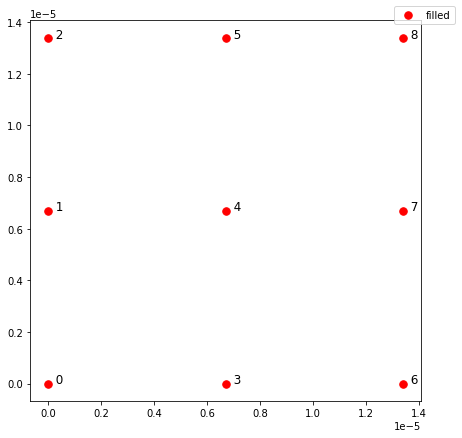

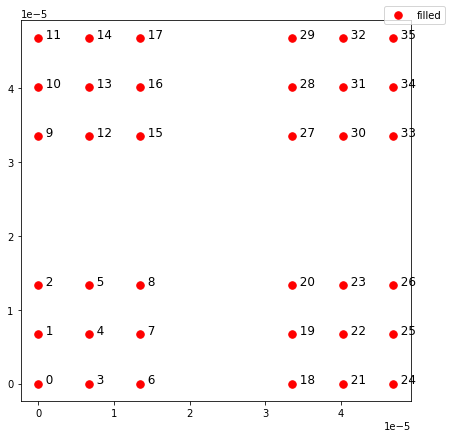

In [8]:
# [Optional] We visually inspect the register
from ahs_utils import show_register

show_register(register)
show_register(parallel_register)

## AHS program for creating the checkerboard phase

We use the same values and timings for the Amplitude, Phase, and Detuning from the [Ordered phases in Rydberg Systems](./02_Ordered_phases_in_Rydberg_systems.ipynb) example 

In [9]:
from ahs_utils import get_drive

time_points = [0, 2.5e-7, 2.75e-6, 3e-6] # s

amplitude_min = 0
amplitude_max = 1.5708e7  # rad / s

detuning_min = -5.49778714e7  # rad / s
detuning_max = 5.49778714e7   # rad / s

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

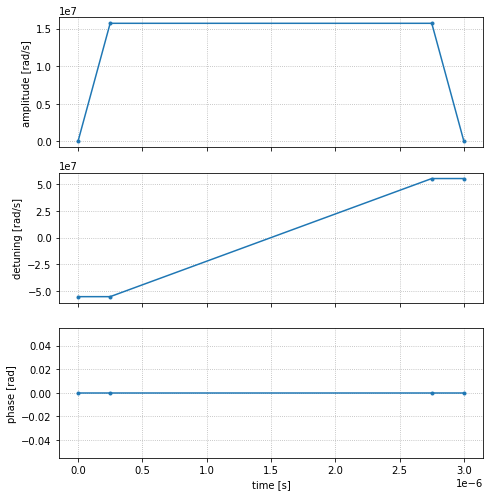

In [10]:
from ahs_utils import show_global_drive

# [Optional] We visually inspect the time series

show_global_drive(drive);

We now construct the AHS program to be run. Note that we create two programs and execute them to allow us to compare the accuracy of our results, with `parallel_ahs_program` being run on Aquila and `ahs_program` just being simulated with the local simulator. 

In [11]:
parallel_ahs_program = AnalogHamiltonianSimulation(
    register=parallel_register, 
    hamiltonian=drive
)

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

ahs_program = ahs_program.discretize(qpu)
parallel_ahs_program = parallel_ahs_program.discretize(qpu)

## Run on simulator

First, we run a non-parallelized register on the local simulator, and sample 400 shots. Below we also explicitly specified the values of `steps`, which are the number of time steps in the simulation.

In [12]:
from braket.devices import LocalSimulator
sim = LocalSimulator("braket_ahs")

sim_result = sim.run(ahs_program, shots=400, steps=100).result()

We compute the average Rydberg density on the 9 sites.

In [13]:
from ahs_utils import get_avg_density

sim_density = get_avg_density(sim_result)

## Run on Aquila

Next, we run a the parallelized register on the QPU. This time, we only need to run 100 shots to get to the same statistical certainty, because we are running four batches in parallel in each shot.

<div class="alert alert-block alert-info">
<b>Note: </b> Some atoms may be missing even if the shot was successful. We recommend comparing <code>pre_sequence</code> of each shot with the requested atom filling in the AHS program specification.  
</div>

In [14]:
# This cell submits the task, waits for its completion, and gets the results.
# To check the status of the task, go to the Amazon Braket tasks page at
# https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/tasks

qpu_result = qpu.run(parallel_ahs_program, shots=100).result()

In [15]:
# collecting QPU Data

all_sequences = []
for measurement in qpu_result.measurements:
    # iterate over key and values
    for (ix,iy),inds in batch_mapping.items():
        batch_sequence = list(measurement.post_sequence[inds])
        all_sequences.append(batch_sequence)

all_rydberg = 1 - np.array(all_sequences)
qpu_density = all_rydberg.mean(axis=0)

After running the separate programs, we can analyze the results.

We average the data across all the batches that ran in parallel across multiple shots, represented visually as a single batch versus the simulator result which just ran a single batch.

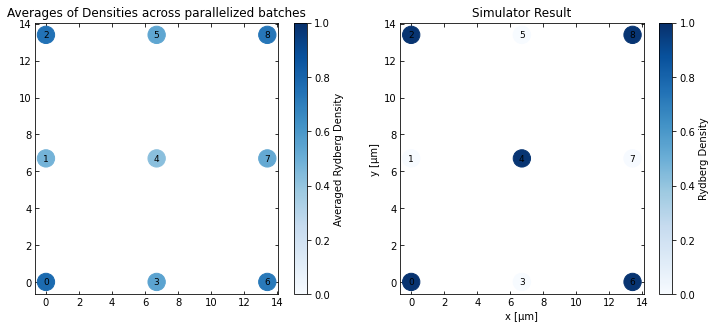

In [16]:
import matplotlib.pyplot as plt
from ahs_utils import plot_avg_density_2D

# Compare results side-by-side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# plot density of all batches that ran in parallel with geometry and averaged values of single batch

plot_avg_density_2D(qpu_density, parallel_register, batch_mapping=batch_mapping, custom_axes = ax1);
ax1.set_title("Averages of Densities across parallelized batches");

# plot density of simulator result
plot_avg_density_2D(sim_density, register, custom_axes = ax2);
ax2.set_title("Simulator Result");

plt.show()

As we can see from the results, the simulated single batch result and the results from the batches running in parallel line up with what we expect for the checkerboard phase.

In [ ]:
print("Task Summary")
print(tracker.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")